In [1]:
# CURVAS DE VALIDACIÓN
# ==================================================
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, log_loss
import xgboost as xgb

# Generar un conjunto de datos de clasificación sintético
X, y = make_classification(
    n_samples=30000, 
    n_features=20, 
    n_classes=2, 
    random_state=42
)

# Espacio de Hiperparámetros
valores_linealmente_separados = 25
hyperparameters = {
    'learning_rate': np.linspace(1e-4, 1e-1, valores_linealmente_separados),
    'n_estimators': np.linspace(10, 1000, valores_linealmente_separados, dtype=int),
    'max_depth': np.arange(3, 7, 1),
    'alpha': np.linspace(0, 10, valores_linealmente_separados),
    'gamma': np.linspace(1e-3, 1e-1, valores_linealmente_separados),
    'lambda': np.linspace(1e-4, 1e-1, valores_linealmente_separados), 
    'subsample': np.linspace(0.5, 0.9, valores_linealmente_separados), 
    'colsample_bytree': np.linspace(0.5, 0.9, valores_linealmente_separados)
}

# Diccionarios para almacenar los mejores valores de hiperparámetros
best_values_log_loss = dict()
best_values_balanced_acc = dict()

# Iterar sobre cada hiperparámetro para evaluar y graficar
for hp_name, hp_values in hyperparameters.items():
    # Resultados para log-loss y balanced accuracy
    results_log_loss = np.zeros((len(hp_values), 4))
    results_balanced_acc = np.zeros((len(hp_values), 4))

    # Evaluación del modelo
    for i, value in enumerate(hp_values):
        kwargs = {hp_name: value}
        model = xgb.XGBClassifier(
            eval_metric='logloss', 
            tree_method='gpu_hist', 
            **kwargs
        )
        
        # Validación cruzada
        cv_results = cross_validate(
            model, 
            X, 
            y, 
            cv=10,
            scoring={'log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True), 
                     'balanced_acc': 'balanced_accuracy'}, return_train_score=True,
            n_jobs=-1
        )
        
        results_log_loss[i] = -np.mean(cv_results['train_log_loss']), np.std(cv_results['train_log_loss']), \
                              -np.mean(cv_results['test_log_loss']), np.std(cv_results['test_log_loss'])
                              
        results_balanced_acc[i] = np.mean(cv_results['train_balanced_acc']), np.std(cv_results['train_balanced_acc']), \
                                  np.mean(cv_results['test_balanced_acc']), np.std(cv_results['test_balanced_acc'])

    mean_train_log_loss, std_train_log_loss, mean_valid_log_loss, std_valid_log_loss = results_log_loss.T
    mean_train_balanced_acc, std_train_balanced_acc, mean_valid_balanced_acc, std_valid_balanced_acc = results_balanced_acc.T

    # Encontrar valores óptimos
    min_log_loss_index = np.argmin(mean_valid_log_loss)
    max_balanced_acc_index = np.argmax(mean_valid_balanced_acc)
    best_values_log_loss[hp_name] = hp_values[min_log_loss_index]
    best_values_balanced_acc[hp_name] = hp_values[max_balanced_acc_index]

    # Creación de subplots
    fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.1)

    # Subplot 1: Log-Loss
    fig.add_trace(go.Scatter(x=hp_values, y=mean_train_log_loss, name='Train set', mode='lines+markers', line=dict(color='crimson'), showlegend=False), row=1, col=1)
    fig.add_trace(go.Scatter(x=hp_values, y=mean_valid_log_loss, name='Validation set', mode='lines+markers', line=dict(color='seagreen'), showlegend=False), row=1, col=1)
    fig.add_trace(go.Scatter(x=[hp_values[min_log_loss_index]], y=[mean_valid_log_loss[min_log_loss_index]], name='Optimal value', mode='markers', marker=dict(color='gold', size=7.5), showlegend=False), row=1, col=1)
    fig.select_legends()

    # Subplot 2: Balanced Accuracy
    fig.add_trace(go.Scatter(x=hp_values, y=mean_train_balanced_acc, name='Train set', mode='lines+markers', line=dict(color='crimson'), showlegend=False), row=1, col=2)
    fig.add_trace(go.Scatter(x=hp_values, y=mean_valid_balanced_acc, name='Validation set', mode='lines+markers', line=dict(color='seagreen'), showlegend=False), row=1, col=2)
    fig.add_trace(go.Scatter(x=[hp_values[max_balanced_acc_index]], y=[mean_valid_balanced_acc[max_balanced_acc_index]], name='Optimal value', mode='markers', marker=dict(color='gold', size=7.5), showlegend=False), row=1, col=2)

    # Actualizar configuración del layout
    fig.update_layout(title=f'Curvas de Validación', template='plotly_dark', width=1640, height=640)
    fig.update_xaxes(title_text=f'\n{hp_name}', row=1, col=1)
    fig.update_yaxes(title_text='Log-Loss\n', row=1, col=1)
    fig.update_xaxes(title_text=f'\n{hp_name}', row=1, col=2)
    fig.update_yaxes(title_text='Balanced Accuracy\n', row=1, col=2)

    fig.show()

In [2]:
# SEPARAR EN CONJUNTOS DE ENTRENAMIENTO/VALIDACIÓN/PRUEBA
# ==================================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, log_loss

# Dividir en conjuntos por 60% entrenamiento, 20% validación y 20% prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.4, random_state=42)  
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)

# Entrenar un modelo de clasificación
model.set_params(**best_values_log_loss)
model.fit(X_train, y_train)

def evaluate_performance(y_true, y_pred, y_pred_proba, set_name=""):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    logloss = log_loss(y_true, y_pred_proba)

    print(f'{set_name} set')
    print('='*18)
    print('Evaluar Desempeño')
    print('='*18)
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Log Loss: {logloss:.4f}\n')

In [3]:
# EVALUAR EL DESEMEPEÑO
# ==================================================
# Entrenar el clasificador
model.set_params(**best_values_log_loss)
model.fit(X_train, y_train)

# Evaluar el conjunto de entrenamiento
y_pred_train = model.predict(X_train)
y_pred_proba_train = model.predict_proba(X_train)[:, 1]
evaluate_performance(y_train, y_pred_train, y_pred_proba_train, 'Train')

# Evaluar el conjunto de validación
y_pred_val = model.predict(X_val)
y_pred_proba_val = model.predict_proba(X_val)[:, 1]
evaluate_performance(y_val, y_pred_val, y_pred_proba_val, 'Validation')

# Evaluar el conjunto de prueba
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]
evaluate_performance(y_test, y_pred_test, y_pred_proba_test, 'Test')

Train set
Evaluar Desempeño
Precision: 0.9019
Recall: 0.9029
F1 Score: 0.9024
ROC AUC: 0.9668
Log Loss: 0.2632

Validation set
Evaluar Desempeño
Precision: 0.9035
Recall: 0.9014
F1 Score: 0.9024
ROC AUC: 0.9641
Log Loss: 0.2656

Test set
Evaluar Desempeño
Precision: 0.8942
Recall: 0.9044
F1 Score: 0.8993
ROC AUC: 0.9624
Log Loss: 0.2726



In [4]:
# MATRIZ DE CONFUSIÓN
# ==================================================
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, set_name=""):
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    
    # Crear la figura de Plotly
    fig = ff.create_annotated_heatmap(
        z=cm, 
        x=class_names, 
        y=class_names, 
        colorscale='magma', 
        showscale=True,
        annotation_text=np.array(cm).astype(str)
    )
    
    # Actualizar el layout
    fig.update_layout(
        title_text=f'Matriz de Confusión para el Conjunto de {set_name}',
        xaxis=dict(title='Predicción'),
        yaxis=dict(title='Verdadero'),
        width=600, height=600,
        template='plotly_dark',
    )
    
    # Mostrar la figura
    fig.show()


# Asumiendo que class_names es una lista con los nombres de las clases
class_names = ['Clase 0', 'Clase 1']

# Visualizar la matriz de confusión para el conjunto de entrenamiento
plot_confusion_matrix(y_train, y_pred_train, class_names, 'Train')

# Visualizar la matriz de confusión para el conjunto de validación
plot_confusion_matrix(y_val, y_pred_val, class_names, 'Validation')

# Visualizar la matriz de confusión para el conjunto de prueba
plot_confusion_matrix(y_test, y_pred_test, class_names, 'Test')

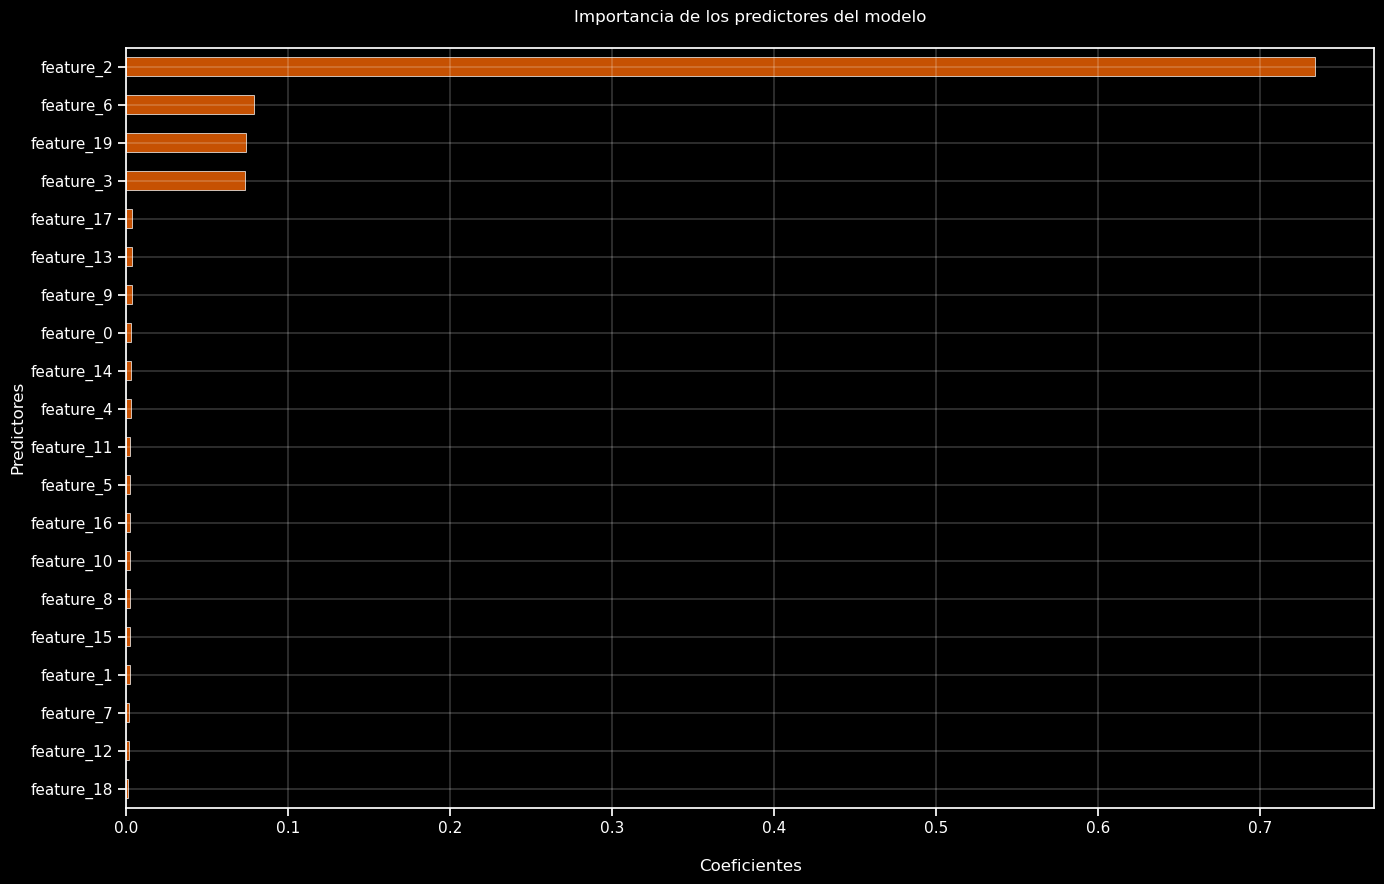

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style=plt.style.use('dark_background'))

# Pesos de los coeficientes
coeficientes = dict(zip([f'feature_{ft}' for ft in range(X_train.shape[1])], [predictor for predictor in model.feature_importances_]))
coef_df = pd.DataFrame.from_dict(coeficientes, orient='index', columns=['coeficientes'])

# Graficar barras horizontales
coef_df.sort_values('coeficientes', ascending=True).plot.barh(figsize=(14, 9), color='xkcd:dark orange', width=0.5,
                                                              edgecolor='white', lw=0.5, legend=False)

# Agregar etiquetas y títulos
plt.title('Importancia de los predictores del modelo\n')
plt.xlabel('\nCoeficientes')
plt.ylabel('Predictores')
plt.grid(color='white', linestyle='-', linewidth=0.25)
plt.tight_layout()

In [7]:
# SEPARAR EN CONJUNTOS DE ENTRENAMIENTO/VALIDACIÓN/PRUEBA
# ==================================================
# Filtrar y hacer el modelo menos complejo
X_filtered = X[:, [2, 6, 19, 3]]

# Dividir en conjuntos por 60% entrenamiento, 20% validación y 20% prueba
X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y, stratify=y, test_size=0.4, random_state=42)  
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)

# Entrenar un modelo de clasificación
model.set_params(**best_values_log_loss)
model.fit(X_train, y_train)

XGBClassifier(alpha=8.333333333333334, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.029875000000000002, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.091675,
              learning_rate=0.07918750000000001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=51, n_jobs=None, num_parallel_tree=None, ...)

In [8]:
# EVALUAR EL DESEMEPEÑO
# ==================================================
# Entrenar el clasificador
model.set_params(**best_values_log_loss)
model.fit(X_train, y_train)

# Evaluar el conjunto de entrenamiento
y_pred_train = model.predict(X_train)
y_pred_proba_train = model.predict_proba(X_train)[:, 1]
evaluate_performance(y_train, y_pred_train, y_pred_proba_train, 'Train')

# Evaluar el conjunto de validación
y_pred_val = model.predict(X_val)
y_pred_proba_val = model.predict_proba(X_val)[:, 1]
evaluate_performance(y_val, y_pred_val, y_pred_proba_val, 'Validation')

# Evaluar el conjunto de prueba
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]
evaluate_performance(y_test, y_pred_test, y_pred_proba_test, 'Test')

Train set
Evaluar Desempeño
Precision: 0.8987
Recall: 0.9060
F1 Score: 0.9023
ROC AUC: 0.9641
Log Loss: 0.2663

Validation set
Evaluar Desempeño
Precision: 0.9001
Recall: 0.9067
F1 Score: 0.9034
ROC AUC: 0.9623
Log Loss: 0.2671

Test set
Evaluar Desempeño
Precision: 0.8918
Recall: 0.9060
F1 Score: 0.8988
ROC AUC: 0.9609
Log Loss: 0.2737



In [9]:
# Visualizar la matriz de confusión para el conjunto de entrenamiento
plot_confusion_matrix(y_train, y_pred_train, class_names, 'Train')

# Visualizar la matriz de confusión para el conjunto de validación
plot_confusion_matrix(y_val, y_pred_val, class_names, 'Validation')

# Visualizar la matriz de confusión para el conjunto de prueba
plot_confusion_matrix(y_test, y_pred_test, class_names, 'Test')